In [14]:
install.packages("caret")
library("caret")
install.packages("magrittr")
library("magrittr")
install.packages("dplyr")
library("dplyr")
install.packages("tidyr")
library("tidyr")
install.packages("lmtest")
library("lmtest")
install.packages("popbio")
library("popbio")
install.packages("e1071")
library("e1071")
install.packages("readxl")
library("readxl")

Warning message:
"package 'caret' is in use and will not be installed"
Warning message:
"package 'magrittr' is in use and will not be installed"
Warning message:
"package 'dplyr' is in use and will not be installed"
Warning message:
"package 'tidyr' is in use and will not be installed"
Warning message:
"package 'lmtest' is in use and will not be installed"
Installing package into 'C:/Users/jacki/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)



package 'popbio' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\jacki\AppData\Local\Temp\RtmpwT5LnU\downloaded_packages



Attaching package: 'popbio'


The following object is masked from 'package:caret':

    sensitivity


Installing package into 'C:/Users/jacki/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)




  There is a binary version available but the source version is later:
      binary source needs_compilation
e1071 1.7-11 1.7-12              TRUE

  Binaries will be installed
package 'e1071' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\jacki\AppData\Local\Temp\RtmpwT5LnU\downloaded_packages


Warning message:
"package 'readxl' is in use and will not be installed"


In [10]:
minerals = read_excel('C:/Users/jacki/OneDrive/Desktop/Entity/DSO106C Machine Learning and Modeling/mineralss.xlsx')

In [12]:
head(minerals)

Antimony,Gold
<dbl>,<dbl>
3.08,1
6.15,1
2.35,1
0.30,0
0.30,0
9.62,1


# Complete logistic regression in R. Make sure to test, note, and correct for all assumptions if possible!

## Test for appropriate sample size

In [15]:
mylogit <- glm(Gold ~ Antimony, data=minerals, family="binomial")

In [16]:
probabilities <- predict(mylogit, type = "response")

In [17]:
probabilities <- predict(mylogit, type = "response")
minerals$Predicted <- ifelse(probabilities > .5, "pos", "neg")

In [18]:
minerals$PredictedR <- NA
minerals$PredictedR[minerals$Predicted=='pos'] <- 1
minerals$PredictedR[minerals$Predicted=='neg'] <- 0

In [19]:
minerals$PredictedR <- as.factor(minerals$PredictedR)
minerals$Gold <- as.factor(minerals$Gold)

In [20]:
conf_mat <- caret::confusionMatrix(minerals$PredictedR, minerals$Gold)
conf_mat

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 34  8
         1  2 20
                                          
               Accuracy : 0.8438          
                 95% CI : (0.7314, 0.9224)
    No Information Rate : 0.5625          
    P-Value [Acc > NIR] : 1.615e-06       
                                          
                  Kappa : 0.6748          
                                          
 Mcnemar's Test P-Value : 0.1138          
                                          
            Sensitivity : 0.9444          
            Specificity : 0.7143          
         Pos Pred Value : 0.8095          
         Neg Pred Value : 0.9091          
             Prevalence : 0.5625          
         Detection Rate : 0.5312          
   Detection Prevalence : 0.6562          
      Balanced Accuracy : 0.8294          
                                          
       'Positive' Class : 0               
                                    

#### 34 cases failed as planned and 20 cases passed as planned. 8 cases passed when predicted to fail and 2 cases failed when predcited to pass. There is a 82.9% accuracy rate. Howewver, if any of the four numbers in the 2x2 chart is below zero, this does meet the minimum sample size for binary logistic regression. 2<5 so this does not meet the sample size. 

## Logit Linearity

In [21]:
minerals1 <- minerals %>% 
dplyr::select_if(is.numeric)

In [22]:
predictors <- colnames(minerals1)

In [23]:
minerals1 <- minerals1 %>%
mutate(logit=log(probabilities/(1-probabilities))) %>%
gather(key= "predictors", value="predictor.value", -logit)

`geom_smooth()` using formula 'y ~ x'



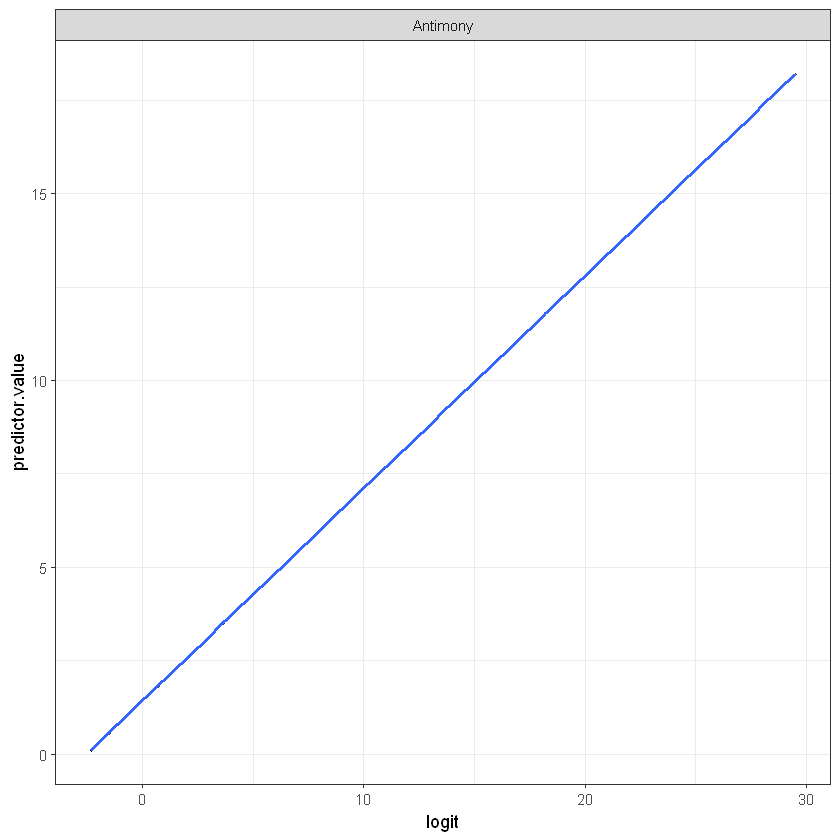

In [24]:
ggplot(minerals1, aes(logit, predictor.value))+
geom_point(size=.5, alpha=.5)+
geom_smooth(method= "loess")+
theme_bw()+
facet_wrap(~predictors, scales="free_y")

#### Shows a lienar relationship, so good to move on to testing the next assumption

## Multicollinearity

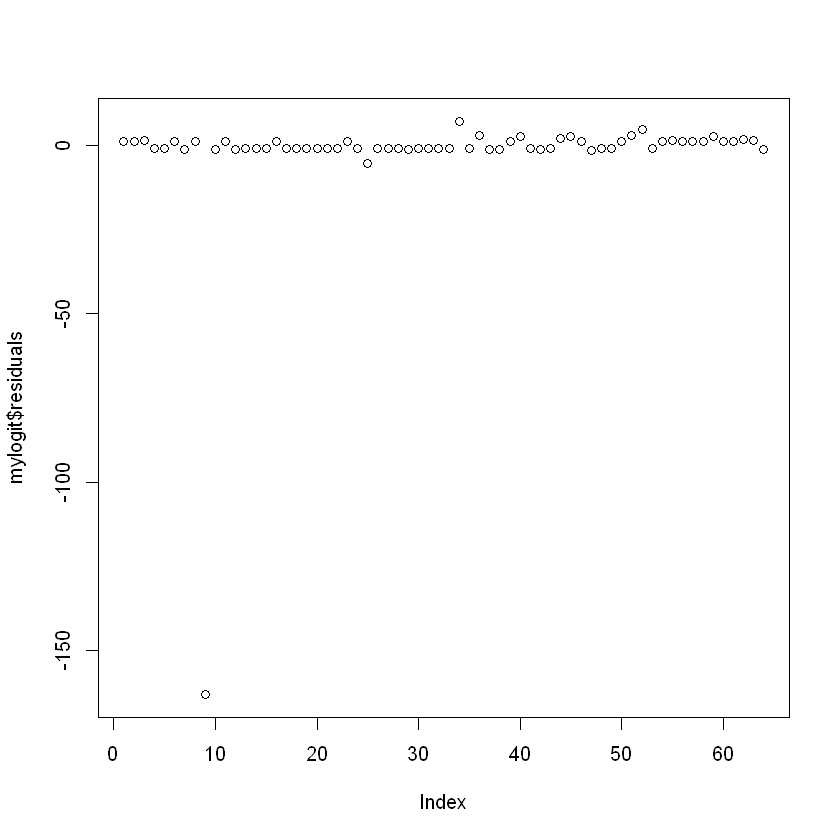

In [25]:
plot(mylogit$residuals)

#### Pretty even distribution of points all the way across the x-axis, so met the assumption of independent errors.

In [26]:
dwtest(mylogit, alternative="two.sided")


	Durbin-Watson test

data:  mylogit
DW = 1.7616, p-value = 0.3316
alternative hypothesis: true autocorrelation is not 0


#### P-value is > 0.05 so the test is statistically significant and the errors are independent.

## Screening for outliers

In [27]:
infl <- influence.measures(mylogit)
summary(infl)

Potentially influential observations of
	 glm(formula = Gold ~ Antimony, family = "binomial", data = minerals) :

   dfb.1_ dfb.Antm dffit   cov.r   cook.d  hat  
3  -0.08   0.20     0.22    1.11_*  0.01    0.08
9   0.35  -0.55    -0.57_*  0.63_*  1.46_*  0.02
25  0.26  -0.62    -0.72_*  0.95    0.23    0.08
34  0.38  -0.22     0.39    0.88_*  0.08    0.03
46 -0.08   0.17     0.19    1.11_*  0.01    0.08
57 -0.08   0.18     0.20    1.11_*  0.01    0.08
63 -0.08   0.22     0.26    1.10_*  0.01    0.08


#### Outliers should be examined and possibly removed if hat is greater than 0.3. None of these outliers meet that criterion, so the dataset is fine as is.

## Interpreting Logistic model

In [28]:
summary(mylogit)


Call:
glm(formula = Gold ~ Antimony, family = "binomial", data = minerals)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1918  -0.5462  -0.4471   0.2447   1.9748  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.5184     0.5958  -4.227 2.37e-05 ***
Antimony      1.7606     0.4883   3.606 0.000311 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 87.720  on 63  degrees of freedom
Residual deviance: 45.332  on 62  degrees of freedom
AIC: 49.332

Number of Fisher Scoring iterations: 7


#### P-value of Antimony is < 0.001. This means that the amount of Antimony is a significant predictor of gold being nearby. The estimate shows how much Antimony influences the finding of gold, meaning that for every unit increase in Antimony, the odds of finding gold nearby are increased by 1.76.

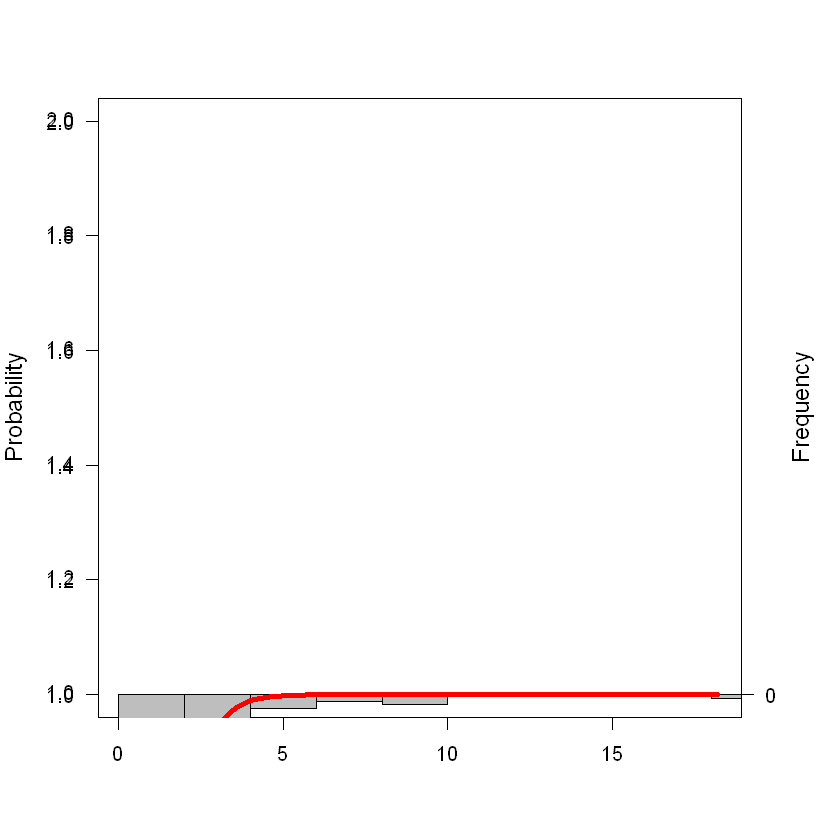

In [29]:
logi.hist.plot(minerals$Antimony,minerals$Gold, boxp=FALSE, type="hist", col="gray")